# Getting started with Fermat
 
Here we introduce the basic concepts in order to compute Fermat distance using the `fermat` package. The systax of `fermat` follows the convention of `sklearn`. In order to ilustrate the use of the Fermat distance for clustering, we are going to construct a systhetic data set and perform K-Medoids on it to estimate the clusters. 

In [1]:
import numpy as np
from scipy.spatial import  distance_matrix
#from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

#from generate_data import generate_swiss_roll

In [2]:
#import os
#import sys
#sys.path.append(os.path.dirname(get_ipython().starting_dir))

For instructions of how to install Fermat, please refer to INSTALLATION

If you need further explanations of how to use the package, you can check on the documentation or use the `help(Fermat)` for it

In [3]:
from fermat import Fermat

## Data generation

We first generate the Swiss Roll data set by sampling a distribution in two dimensions and then embedding it in three dimensions.

In [25]:
oscilations = 15
a = 3
n = 500

mean1 = [0.3, 0.3]
mean2 = [0.3, 0.7]
mean3 = [0.7, 0.3]
mean4 = [0.7, 0.7]
cov = [[0.01, 0], [0, 0.01]]

x1 = np.random.multivariate_normal(mean1, cov, n)
x2 = np.random.multivariate_normal(mean2, cov, n)
x3 = np.random.multivariate_normal(mean3, cov, n)
x4 = np.random.multivariate_normal(mean4, cov, n)
xx = np.concatenate((x1, x2, x3, x4), axis=0)

labels = [0] * n + [1] * n + [2] * n + [3] * n

X = np.zeros((xx.shape[0], 3))

for i in range(X.shape[0]):
    x, y = xx[i, 0], xx[i, 1]
    X[i, 0] = x * np.cos(oscilations * x)
    X[i, 1] = a * y
    X[i, 2] = x * np.sin(oscilations * x)

In [26]:
#X, labels = generate_swiss_roll(oscilations = 15, a = 3, n = 250)
#print('Data dimension:{}'.format(data.shape))


Visualize the data

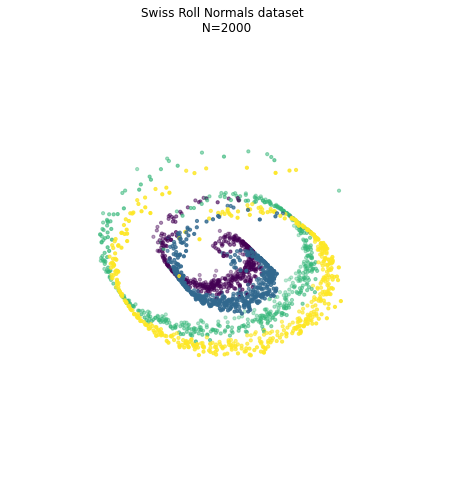

In [27]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 80)
ax.set_axis_off()
ax.scatter(xs=X[:,0], ys=X[:,1], zs=X[:,2], c=labels, s=10)
plt.title('Swiss Roll Normals dataset \n N=%s'%(X.shape[0]))

plt.show()

First, we compute the Euclidean distances between points in the data set

In [28]:
distances = distance_matrix(X, X)

## Computing Fermat-Distances

The Fermat distance is computed based on certain parameters that we can customized. The most important one is `alpha`, which indicates the power of the Euclidean distance we use as weight when computing the minimal path. 

In [29]:
alpha = 3

### Exact method: computes all the pairwise Fermat distances in an exact way

This methods computes the exact Fermat distance by calculating the shortness path of the fully connected graph. For this, we use the Floyd-Warshall algorithm.


In [30]:
%%time

# Initialize the model
f_exact = Fermat(alpha = alpha, path_method='FW') 

# Fit the model
f_exact.fit(distances)

CPU times: user 7.81 s, sys: 72.3 ms, total: 7.88 s
Wall time: 7.9 s


Fermat(alpha=3, path_method='FW')

We can now access the distance between each pair of points

In [31]:
f_exact.get_distance(0,1)

0.0008847103500690737

and also the full distance matrix:

In [32]:
fermat_dist_exact = f_exact.get_distances() 
fermat_dist_exact.shape

(2000, 2000)

### Aproximate method 1: using k-nearest neighbours

Since consecutive points of the Fermat distance tend to be close to each other, we can estimate the Fermat distance by restricting the shortness path to be included in the k-nearest neighbours graph. Using Dijkstra algorithm, we can reduce the total cost of computing the Fermat distance for this case. 

In [38]:
%%time

k = 20

# Initialize Fermat model
f_aprox_D = Fermat(alpha, path_method='D', k=k) 

# Fit
f_aprox_D.fit(distances)

CPU times: user 2.42 s, sys: 21.5 ms, total: 2.44 s
Wall time: 2.44 s


Fermat(alpha=3, k=20, path_method='D')

In [39]:
fermat_dist_aprox_D = f_aprox_D.get_distances()

### Aproximate method 2: using landmarks and k-nearest neighbours 

In [41]:
%%time

landmarks = 30

# Initialize Fermat model
f_aprox_L = Fermat(alpha, path_method='L', k=k, landmarks=landmarks) 

# Fit
f_aprox_L.fit(distances)

CPU times: user 943 ms, sys: 19.8 ms, total: 963 ms
Wall time: 967 ms


Fermat(alpha=3, k=20, landmarks=30)

In [42]:
%%time
fermat_dist_aprox_L = f_aprox_L.get_distances() 

CPU times: user 1min 20s, sys: 104 ms, total: 1min 20s
Wall time: 1min 20s


### Comparision between methods

We can evaluate the performance of the approximate methods by comparing the relative error between them and the distance computed on the fully connected graph.

For the restiction to the k-nearest neighbours graph, we observe small discrepancies. Notice that the scale of the histogram is logarithmic in the y-axis. 

/var/folders/bl/07xln3hx6k51cbfm24kn3dnm0000gn/T/ipykernel_72198/1753812870.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(np.divide(fermat_dist_aprox_D, fermat_dist_exact).flatten(), range=(0,4), bins=100, log=True);


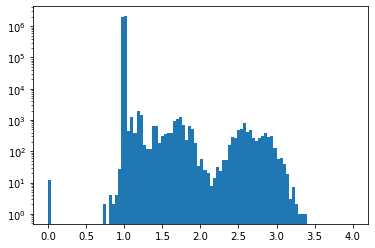

In [40]:
plt.hist(np.divide(fermat_dist_aprox_D, fermat_dist_exact).flatten(), range=(0,4), bins=100, log=True);

and the same for the method based on landmarks.

/var/folders/bl/07xln3hx6k51cbfm24kn3dnm0000gn/T/ipykernel_72198/552554338.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.hist(np.divide(fermat_dist_aprox_L, fermat_dist_exact).flatten(), range=(0,4), bins=100, log=True);


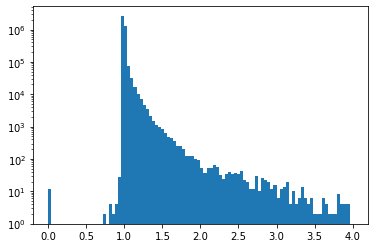

In [44]:
plt.hist(np.divide(fermat_dist_aprox_L, fermat_dist_exact).flatten(), range=(0,4), bins=100, log=True);

## Visualization

Visualization for the Fermat distances using t-SNE

In [21]:
tsne_model = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=500)
tsnes = tsne_model.fit_transform(fermat_dist_exact)

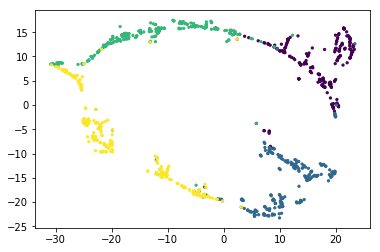

In [22]:
plt.scatter(tsnes[:,0],tsnes[:,1], c = labels, s = 5)